# Naive Classifier for Fake news recognition

In [1]:
source('naive_bayes.R') # load the proper functions to perform the computations

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [2]:
numCores <- detectCores() # for the parallel execution of code later on

# Reading the data
Here we first load the dataset in order to explore its columns and perform some normalization

In [3]:
train.filename <- "dataset/archive/train.csv"  # paths to dataset files
test.filename <- "dataset/archive/test.csv"  #

In [4]:
train.df <- read.delim(train.filename, sep = ",")  # actually load the files
test.df <- read.delim(test.filename, sep = ",")  #

## Display the train and test datasets
This is done in order to check the dataset schema.

`test.df` does not have the assigned Labels. We therefore are going to split the training dataset in actual training and validation sets to check the accuracy of the algorithm. 

In [5]:
head(train.df)

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


In [6]:
head(test.df)

,Text,Text_Tag
,<chr>,<chr>
1,Building a wall on the U.S.-Mexico border will take literally years.,immigration
2,Wisconsin is on pace to double the number of layoffs this year.,jobs
3,Says John McCain has done nothing to help the vets.,"military,veterans,voting-record"
4,Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.,"medicare,message-machine-2012,campaign-advertising"
5,"When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.","campaign-finance,legal-issues,campaign-advertising"
6,Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.,"federal-budget,pensions,retirement"


# Splitting the datasets

In [8]:
set.seed(29062023) # seed for code reproducibility 
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [9]:
# set splitting percentages
perc_split <- 0.8  # 80% of original dataset is for training and 20% for validation
n_rows <- nrow(train.df)
n_rows_train <- floor(n_rows * perc_split)

# splitting
train.df.train <- train.df[1:n_rows_train, ] # takes the first n_rows
train.df.validation <- train.df[-c(1:n_rows_train), ] # takes the remaining rows

In [10]:
# show the splittings
cat('Total rows:',nrow(train.df),
    '\nTrain rows:',nrow(train.df.train),
    '\nValidation rows',nrow(train.df.validation))

Total rows: 10240 
Train rows: 8192 
Validation rows 2048

# Labels distribution and prior definition
This is a necessary step in oder to check the distribution of the labels, and therefore compute the associated prior probabilities.

In [43]:
counts_labels<-table(train.df.train$Labels) # count each label

In [45]:
n_classes<-length(counts_labels) # count the number of different labels

## Defining the prior of each class

In [46]:
prior.classes<-counts_labels/sum(counts_labels) # compute the prior for each kind of label

## Show the distribution in a barplot

In [38]:
labels <- c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True')
colors <- c('#FF6666','#FF9966', '#FFCC66', '#99FF99' , '#CCCCCC','#00FF99')

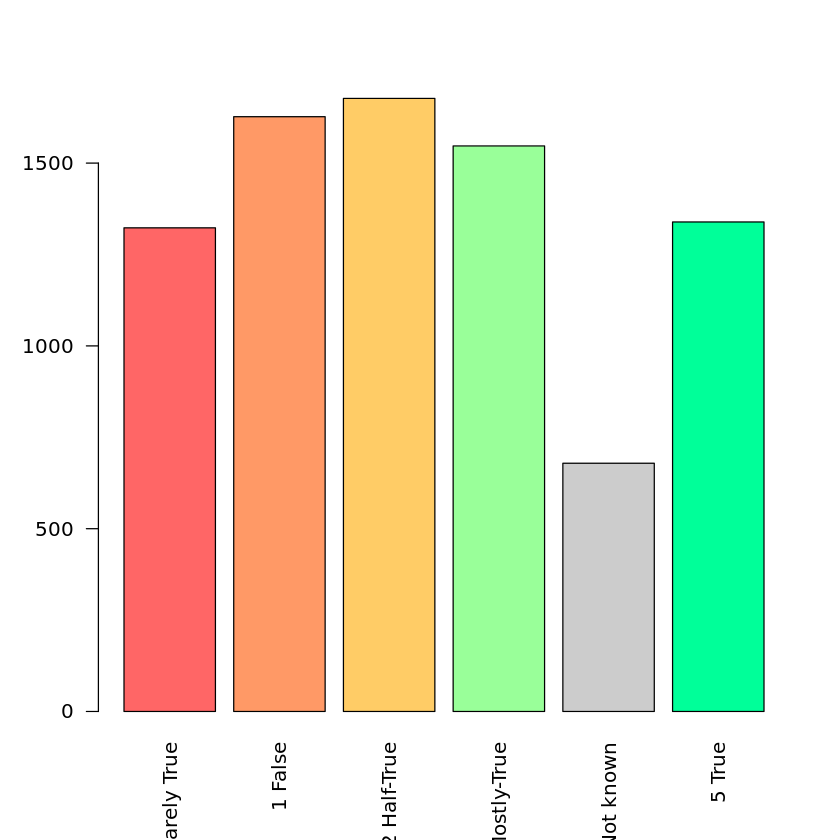

In [48]:
barplot(counts_labels, col=colors, names=paste(0:(n_classes-1),labels), las=2)

# Stop words: those to be ignored
We decided to use the tidytext library which already implements a list of the most common stop words in English as shown below

In [12]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

# Object to use `naive_bayes.R` functions

In [14]:
tags_numbers <- list(tags = labels, numbers = c(0:(n_classes - 1)))

# Training: creating and saving the dfs with words and countings according to feature selection method

In [33]:
fraction <- seq(from = 0.1, to = 1, by = 0.2)

In [34]:
# Return data.frame with only counted and tokenized words
counts <- vocabulary(train.df.train, tags_numbers)

# Run all the functions

In [ ]:
# acc_freq_mean <- vector()
# for (i in seq_along(fraction)) {
#     # Vocabulary optimized with feature selection
#     naive.bayes.vocabulary <- feature_selection.frequency_mean(counts, n_classes,
#         frac = fraction[i])

#     # Compute denominator of likelihood
#     denominator <- likelihood.denominator(naive.bayes.vocabulary)

#     # Compute the likelihood for each tokinez and unique word
#     likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

#     # Run the prediction
#     predicted_classes <- mclapply(X = train.df.validation$Text, FUN = naive.bayes,
#         likelihood.token = likelihood.token, prior.classes = prior.classes, den = denominator,
#         n_classes = n_classes, mc.cores=numCores)

#     # Check % of right predictions
#     acc_freq_mean[i] <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)
# }

In [ ]:
# plot(fraction, acc_per_class, type='l', ylim = c(0,1))
# lines(fraction, acc_freq_mean, col='red')
# legend(0, 1, legend = c("freq mean", "top per class"), col = c("red", "black"), lty = 1)

# Apply to the validation set and plot accuarcies for different methods

In [39]:
file_list <- c(list.files(path = "models", pattern = "frequency_per_mean*"),
               list.files(path = "models", pattern = "frequency_per_class*"),
               list.files(path = "models", pattern = "chi_per_mean*"),
               list.files(path = "models", pattern = "chi_per_class*"),
               list.files(path = "models", pattern = "mutual_per_class*"),
               list.files(path = "models", pattern = "mutual_per_mean*"))

In [41]:
acc<-vector()
for (i in seq_along(file_list)) {

    naive.bayes.vocabulary <- read.csv(paste("./models", file_list[i], sep = "/")) %>%
        select(-X)
    # Compute denominator of likelihood
    denominator <- likelihood.denominator(naive.bayes.vocabulary)

    # Compute the likelihood for each tokinez and unique word
    likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

    # Run the prediction
    predicted_classes <- mclapply(X = train.df.validation$Text, FUN = naive.bayes,
        likelihood.token = likelihood.token, prior.classes = prior.classes, den = denominator,
        n_classes = n_classes, mc.cores = numCores)

    # Check % of right predictions
    acc[i] <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)
}

In [42]:
acc

[1] 0.2153320 0.2192383 0.2031250 0.2031250 0.2031250 0.2031250 0.2031250
 [8] 0.1997070 0.2143555 0.2084961